In [1]:
"""
Created on Fri Sep 22 12:26:33 2017

@author: Manikanda Krishnan V (06-02-02-10-22-17-1-14787)
"""


'\nCreated on Fri Sep 22 12:26:33 2017\n\n@author: Manikanda Krishnan V (06-02-02-10-22-17-1-14787)\n'

An image is padded with extra pixels in order to perform the convolution operation on the boundary pixels. Different types of padding lead to different effects. 

Zero Padding - The boundary are padded with pixels having value 0. This corresponds to ignoring the filter parameters that are outside the image. The disadvantage of this scheme is that it might cause sharp discontinuities at the boundary leading to creation of high frequency components.

Periodic Padding - In this scheme the image is repeated(tiled). This corresponds to periodic convolution, images generally do not satisfy this assumption i.e the texture on the right border can be very different from the left border etc, hence this also leads to discontinuities.

Symmetric Padding - In this scheme the pixels are reflected across the boundary. This leads to smoother transitions at the boundary preventing the creation of high frequency components


In [2]:
def padImage(im,filter_shape,padding_type="zero") :
    im_size = im.shape 
    padding_thickness = [x/2 for x in filter_shape]
    lower_corner = (padding_thickness[0]+im_size[0],padding_thickness[1]+im_size[1])
    im_col_flipped = im[:,-1::-1]
    im_row_flipped = im[-1::-1,:]
    im_both_flipped = im[-1::-1,-1::-1]
    zeros = np.zeros(im_size)
    if padding_type == "zero" :
            new_im = np.vstack([np.hstack([zeros,zeros,zeros]),
                                np.hstack([zeros,im,zeros]),
                                np.hstack([zeros,zeros,zeros])])

    elif padding_type == "symmetric" :
            new_im = np.vstack([np.hstack([im_both_flipped,im_row_flipped,im_both_flipped]),
                                np.hstack([im_col_flipped,im,im_col_flipped]),
                                np.hstack([im_both_flipped,im_row_flipped,im_both_flipped])])
    elif padding_type == "periodic" :
            new_im = np.vstack([np.hstack([im,im,im]),
                                np.hstack([im,im,im]),
                                np.hstack([im,im,im])])

    return new_im[im_size[0]-padding_thickness[0]:2*im_size[0]+padding_thickness[0],im_size[1]-padding_thickness[1]:2*im_size[1]+padding_thickness[1]]

2D convolution - Given a filter (M x P matrix) it is reflected about the origin(180 degree flip), and is then multiplied(elementwise) with the image patch. For an image of size N x N it has a complexity of O(N^2MP) multiplications. 

Padding of the image is done to take convolution at the boundaries


In [3]:
def my_conv2D(image,filt,padding_type="zero") :
    #reflection about origin , center value
    mask = filt[-1::-1,-1::-1]
    mask_shape = mask.shape
    #padding
    im = padImage(image,mask_shape,padding_type)
    new_image = np.zeros(image.shape)
    for x in range(0,image.shape[0]) :
        for y in range(0,image.shape[1]) :
            #element wise multiplication after shifting by x,y
            new_image[x,y] = np.sum(im[x:x+mask_shape[0],y:y+mask_shape[1]]*mask)
    return new_image                      

In [4]:
def my_conv1D(row,filt,padding_type = "zero") :
    #reflection about origin
    mask = filt[-1::-1]
    row.shape = (1,row.shape[0])
    new_row = np.zeros((row.shape[0],row.shape[1]- 2*(mask.shape[1]/2)))
    for y in range(0,row.shape[1] - 2*(mask.shape[1]/2)) :
        #1D dotproduct with shifted filter
        new_row[0,y] = np.sum(row[0,y:y+mask.shape[1]]*mask)
    return new_row

if the filter is of rank 1. Then it can be separated into 2 filters of dimensions (M x 1) and (1 x P). The column vector is then convolved with the columns of the image and the row vector is convolved with the rows of the output of the previous step. This reduces the 2D convolution into 2 1D convolutions with the reulting complexity being O(N^2(M+P)) multiplications. This particular implementation of separable filters seems to have large constant factors and the speedup is observed only for filters of large sizes

In [5]:
def my_conv2D_separable(image,filt_y,filt_x,padding_type="zero") :
    mask_shape = (filt_x.shape[1],filt_y.shape[1])
    im = padImage(image,mask_shape,padding_type)
    (m,n) = im.shape
    #1D convolution with column filter and columns of the image
    conv_y_im = np.vstack([my_conv1D(im[x,:],filt_y,padding_type) for x in range(0,m)])
    (m,n) = conv_y_im.shape
    #1D convolution with row filter and rows of the previous output.
    conv_x_im = np.vstack([my_conv1D(conv_y_im[:,y],filt_x,padding_type) for y in range(0,n)])
    return conv_x_im.T

The convolution using a uniform moving average can be rewritten as a recurrence equation. This results in no multiplications.

In [6]:
def movingAverage(image,size_x,size_y,padding_type ="zero") :
    mask_shape = (size_x,size_y)
    im = padImage(image,mask_shape,padding_type)
    """
    Take moving average across the columns followed by moving average across rows. This works since moving average(uniform) is separable
    """
    y_avg = np.zeros((im.shape[0],image.shape[1]))
    y_avg[:,0] = np.sum(im[:,0:size_y],axis = 1) 
    for i in range(1,y_avg.shape[1]) :
        # add the new column values to previous output and subtract the oldest column
        y_avg[:,i] = y_avg[:,i-1] - im[:,i - 1] + im[:,i+size_y - 1]
    x_avg = np.zeros((image.shape))
    x_avg[0,:] = np.sum(y_avg[0:size_x,:],axis = 0)
    for i in range(1,x_avg.shape[0]) :
        # add the new row values to previous output and subtract the oldest row
        x_avg[i,:] = x_avg[i-1,:] - y_avg[i-1,:] + y_avg[i+size_x-1,:]
    return x_avg/1.0/size_x/size_y

Gaussian filter is a separble filter where the filter coefficients corresponds to gaussian density values. It is a very powerful smoothing filter, but it takes a long time.
Iterated moving average filter is about applying the moving average filter many many times. The simple uniform moving average filter corresponds to a rectangular pulse , repeated convolving the rectangular pulse makes the resulting filter become almost like a gaussian. The iterated moving average approximation to the gaussian filter is preferred due to the very fast algorithm for taking the moving average

original image


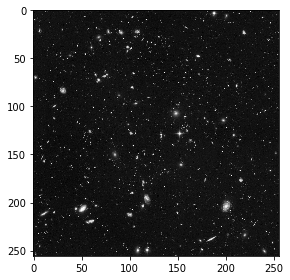

noisy image


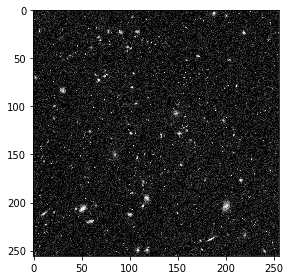

padding type : zero
using gaussian filter


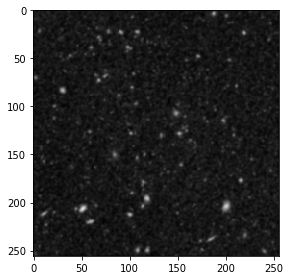

using iterated moving average


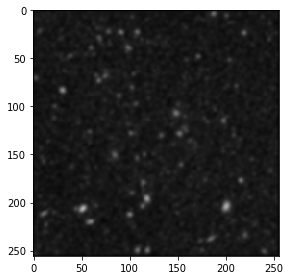

padding type : symmetric
using gaussian filter


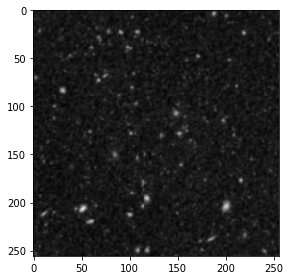

using iterated moving average


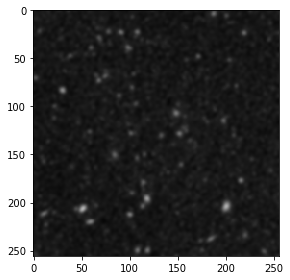

padding type : periodic
using gaussian filter


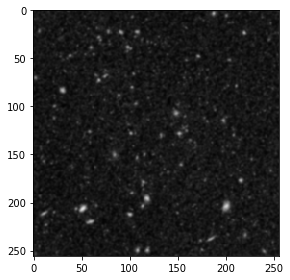

using iterated moving average


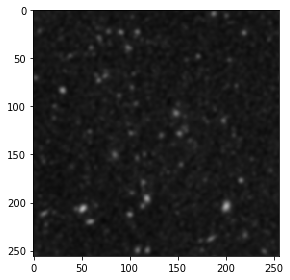

In [9]:
import numpy as np
from skimage import io,color,transform,img_as_ubyte
import matplotlib.pyplot as plt
from  skimage.util import random_noise
import math

#gaussing parameters
mu_x = 0
mu_y = 0
sigma_x = 1
sigma_y = 1
gaussian = lambda mu,sigma: np.array([math.exp(-(i-mu)**2/sigma**2/2.0) for i in range(-3*sigma,3*sigma+1)])/math.sqrt(np.pi*2)/sigma

#calling them masks as gaussian is symmetric about origin.
mask_x = gaussian(mu_x,sigma_x)
mask_y = gaussian(mu_y,sigma_y)
mask_x.shape = (1,6*sigma_x+1)
mask_y.shape = (1,6*sigma_y+1)


natural_path = r"C:\Users\Sephiroth\Downloads\iisc\DIP codes\astronomy.jpg"
padding_type = ["zero","symmetric","periodic"]
print "original image"
iml = transform.resize(color.rgb2gray(io.imread(natural_path)),(256,256))
io.imshow(iml)
plt.show()

print "noisy image"
im = random_noise(iml, mode='gaussian')
io.imshow(im)
plt.show()



for padding in padding_type :
    print "padding type : {}".format(padding)
    print "using gaussian filter"
    output = my_conv2D_separable(im,mask_y,mask_x,padding)
    #output = output/np.max(output[:])
    io.imshow(output)
    plt.show()
    
    print "using iterated moving average"
    im_copy = im[:]
    for i in range(0,4) :
        output = movingAverage(im_copy,2*sigma_y+1,2*sigma_x+1,padding)
        im_copy = output
    io.imshow(output)
    plt.show()



original image


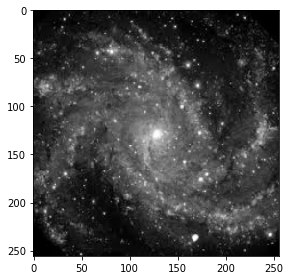

noisy image


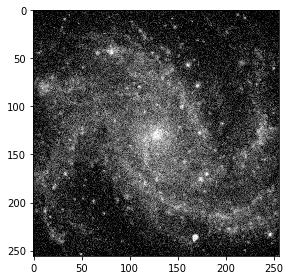

padding type : zero
using gaussian filter


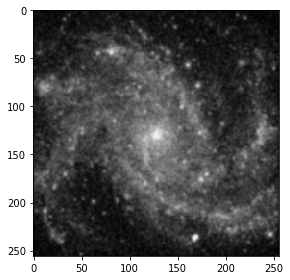

using iterated moving average


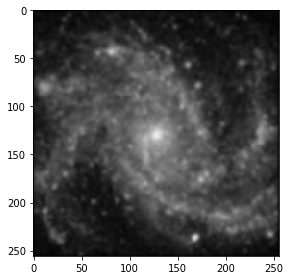

padding type : symmetric
using gaussian filter


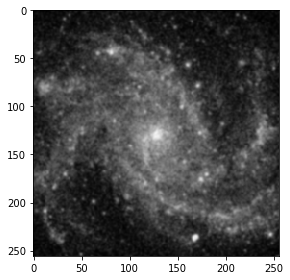

using iterated moving average


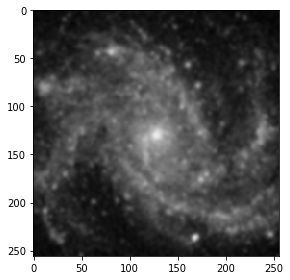

padding type : periodic
using gaussian filter


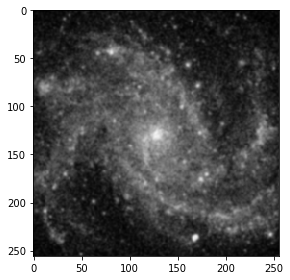

using iterated moving average


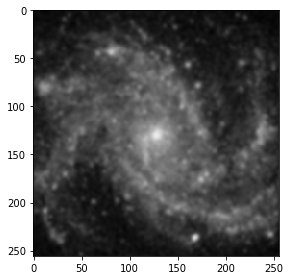

In [10]:
natural_path = r"C:\Users\Sephiroth\Downloads\iisc\DIP codes\astronomy1.jpg"
padding_type = ["zero","symmetric","periodic"]
print "original image"
iml = transform.resize(color.rgb2gray(io.imread(natural_path)),(256,256))
io.imshow(iml)
plt.show()

print "noisy image"
im = random_noise(iml, mode='gaussian')
io.imshow(im)
plt.show()



for padding in padding_type :
    print "padding type : {}".format(padding)
    print "using gaussian filter"
    output = my_conv2D_separable(im,mask_y,mask_x,padding)
    #output = output/np.max(output[:])
    io.imshow(output)
    plt.show()
    
    print "using iterated moving average"
    im_copy = im[:]
    for i in range(0,4) :
        output = movingAverage(im_copy,2*sigma_y+1,2*sigma_x+1,padding)
        im_copy = output
    io.imshow(output)
    plt.show()
